# Final AlphaPose and Downstream Modelling Pipeline

This notebook is an improved pipeline containing all the final modelling elements required for the social distancing system. 

It takes in an input video source (e.g. .mp4 video), and extracts pose features using AlphaPose, followed by applying a range of downstream models to make predictions on various social-distancing risk factors using these pose features for each person in the scene.

The results are used to generate a density heatmap, which is achieved using a top-down view of the scene, obtained through automated homography techniques. This heatmap is then transformed back to the original scene viewpoint, and super-imposed above the original scene. This provides an effective means of highlighted the most risky areas within a scene to airport management personnel and passengers.

These results are intended to be used by the dashboard to display these results to the end-users.

**Noteworthy changes as of 31/03/22:**
- Added risk profile for each frame (calculated by summing all person weights for that frame)
- Added stackplot / lineplot visualisations for results obtained for each video at bottom of notebook

## 1. Installation of dependencies / Importing packages

Install MXNet and Gluoncv libraries. If GPU is in use, also install mxnet-cu101 (requires runtime restart after):

In [1]:
import cv2
import io
import mxnet as mx
import gluoncv

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import PIL.Image as Image
import seaborn as sns
import skimage.io
import tensorflow as tf
import tensorflow_hub as hub

from collections import deque
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord
from gluoncv.utils.viz import cv_plot_image, cv_plot_keypoints, plot_image, cv_plot_bbox
from gluoncv import utils
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from tensorflow import keras
from tqdm import tqdm

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/benjaminfraser/anaconda3/envs/nlp_cp/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
sns.set_style('white')

## 2. Setting up models, data and directories:

### 2.1 Image Classification Model Loading and Initialisation

**Note:** In order to get this working, you need to make sure you've got all of the files from the github repo, including the model and clf_model directory within that. This contains the pre-trained image classification model that is required.

**Option 1**: If working locally on laptop, in file system outside main repo:

In [3]:
# get project path and other key directories for project
#PROJECT_PATH = '/Users/benjaminfraser/Desktop'

# set path to test videos to use in this notebook
#TEST_VIDEO_DIR = os.path.join(PROJECT_PATH, 'test_video_data')

# define our model directory to obtain models as needed
#MODEL_DIR = os.path.join(PROJECT_PATH, 'Multipose_experiments')

**Option 2**: If running code locally within cloned GitHub repo:

In [4]:
# get project path and other key directories for project
PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data')

# set path to test videos to use in this notebook
TEST_VIDEO_DIR = os.path.join(DATA_DIR, 'test_videos')

# define our model directory to obtain models as needed
MODEL_DIR = os.path.join(PROJECT_PATH, 'models')

Only ensure one of the two code snippets above are uncommented, and relate to the correct directories.

Load pre-trained BiT model for mask classification:

In [5]:
# define folder that contains our trained model
saved_model_dir = os.path.join(MODEL_DIR, 'mask_clf_model')

# if not already done, load existing trained model
trained_module = hub.KerasLayer(saved_model_dir, trainable=False)

2022-03-31 10:57:06.353532: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 10:57:18.053311: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 're_lu_48/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2022-03-31 10:57:18.053362: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


Load pre-trained FCNN model for performing behaviour analysis:

In [6]:
# load bahavior analysis model
behavior_analysis_model_dir = os.path.join(MODEL_DIR, 'pose_ana_model', 'four_behavior.h5')
behavior_analysis_model = tf.keras.models.load_model(behavior_analysis_model_dir)

Set up main environment variables for the above mask classification model:

In [7]:
# if images are generally small (smaller than 96 x 96 on avg)
IMG_SIZE = (160, 160)
RESIZE_TO = 128
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# probability theshold for classifying a person as masked
MASK_THRESHOLD = 0.7

# class id map for our mask model predictions
CLASS_ID_MAP = { 0 : 'No Mask',
                 1 : 'Mask'}

# color map dictionary for different classes
COLOR_MAP = {0 : [255.0, 0.0, 0.0],
             1 : [0.0, 255.0, 0.0]}

# ID mappings and color map for behaviour classification
BEH_DIC = {0:"Standing", 1:"Sittting", 2:"Walking", 3:"Lying Down"}
BEH_color = {0:[225, 0, 0], 2:[0, 225, 0], 3:[0, 0, 225], 4:[225, 225, 0]}

# create mappings for pose status risk factors (how they influence social risk)
# 0 = no added risk, 1 = added risk (these are used by the weight computation)
BEH_RISK_FACTORS = {0:0, 1:1, 2:0, 3:1}

In [8]:
# dictionaries mapping outputs from models to useful labels
MASK_PREDS_IDS = { 0 : 'No Mask', 1 : 'Mask'}
SOCIAL_DIST_IDS = { 0 : 'Violating Distance', 1 : 'Safe Distance'}

# specify marker colors depending on mask status
MASK_COLOR_MAP = {'No Mask' : 'tab:red', 'Mask' : 'tab:blue'}

# specify marker style depending on social distancing violation status
DIST_STYLE_MAP = {'Violating Distance' : 'X', 'Safe Distance' : 'o'}

# bandwidth parameter adjustment for gaussian KDE density heatmap
# smaller = less smooth, smaller and more focussed cluster regions
BW_ADJUST = 0.4

# risk factors for each social distancing parameter (used for computing weights)
MASK_FACTOR = 0.5
VIOLATION_FACTOR = 1.0
POSE_STATUS_FACTOR = 0.5

### 2.2 AlphaPose Model Loading and Initialisation

Load and initialise our AlphaPose model (select CPU or GPU as required!):

In [9]:
# initialise our alphapose model - either cpu or gpu subject to architecture
ctx = mx.cpu()
#ctx = mx.gpu()

# load and initialise object detector that feeds into AlphaPose
#detector = get_model('yolo3_darknet53_coco', pretrained=True, ctx=ctx)

# other object detection model options:
# faster & smaller, but slight drop in performance
detector = get_model('yolo3_mobilenet1.0_coco', pretrained=True, ctx=ctx)

# slightly faster, but worse performing option using single-shot-detector:
#detector = get_model('ssd_512_mobilenet1.0_coco', pretrained=True, ctx=ctx)

detector.reset_class(classes=['person'], reuse_weights={'person':'person'})
detector.hybridize()

# Load and initialise AlphaPose model (estimates poses from dectector outputs)
estimator = get_model('alpha_pose_resnet101_v1b_coco', pretrained=True, ctx=ctx)
estimator.hybridize()

We can now apply this AlphaPose model on a desired video / stream, by making predictions on each frame as it is received.

## 3. Defining helper functions for all downstream models

Within this section we require helper functions that allow each of our downstream models to pre-process, make predictions and post-process predictions from the extracted pose features.

### 3.1 Distance estimation helper **functions**

Helper functions for distancing estimation between people within scenes:

In [10]:
def to_3D(xf, yf, xh, yh, f, h=1.5):
    """ Gives the 3D euclidian coordinates of a person (on feet position) given
        its head and feet 2D coordinates in the image, the focal length of the
        camera and the average  (with origin of 3D coordinates system projected
        on the center of the 2D image, center of 2D coordinates system)

    Args:
        xf (float): abscissa of the feet position in the image
        yf (float): ordinate of the feet position in the image
        xh (float): abscissa of the head position in the image
        yh (float): ordinate of the head position in the image
        f (float): focal length of the camera
        h (float): average nose-to-feet height of a person (default 1.5)
                
    Method:
        Remove every error sensible operations or special cases, and do:
        x = xh*h/((f*(1-xh/xf))**2 + ((yh*xf-xh*yf)/xf)**2)**0.5
        H = x/xf*(f*(1-(x*(yh*xf-xh*yf)/(xh*xf*h))**2)**0.5
            - x*yf*(yh*xf-xh*yf)/(xh*xf*h))
        y = x*yf/xf/(1-(x*(yh*xf-xh*yf)/(xf*xh*h))**2)**0.5
        theta = np.arccos(x*(yh*xf-xh*yf)/(xf*xh*h))
    
    Returns:
        x (float): position of the person's feet along x-axis (axis located on the floor)
        y (float): position of the person's feet along y-axis (axis located on the floor)
        theta (float): angle of the camera from the ceiling, in rad
        H (float): height of the camera
    """
    # particular case, avoid division by 0 with simpler equations
    if xf * xh == 0:
        x = 0
        temp1 = (yh - yf)/h

        # case due to high error on the given coordinates
        if abs(temp1) >= 1:
            # fix values such as it can be removed later, in particular with H = -1
            return 0, 0, 0, -1 
        
        temp2 = (1-temp1**2)**0.5
        H = f*temp2 - yf*temp1
        y = yf/temp2
        theta = np.arccos(temp1)

    else:
        # case due to high error or if top view and person in (0, 0)
        if xh == xf and yh == yf:
            # fix values such as it can be removed later, in particular with H = -1
            return 0, 0, 0, -1

        x = xh*h/((f*(1-xh/xf))**2 + (yh-xh*yf/xf)**2)**0.5
        temp1 = (yh/xh - yf/xf)/h

        # case due to high error on the given coordinates
        if abs(x*temp1) >= 1:
            return 0, 0, 0, -1
        
        temp2 = (1-(x*temp1)**2)**0.5
        H = x/xf*(f*temp2 - x*yf*temp1)
        y = x*yf/(xf*temp2)
        theta = np.arccos(x*temp1)
        
    return x, y, theta, H

In [11]:
def from_2D_to_3D(pose_feats, image_dim_x, image_dim_y, theta=None, H=None, f=None):
    """ Gives the 3D euclidian coordinates of the persons in a image (on feet
        position) given their heads and feet 2D coordinates in the image, and
        the dimensions of the image (with origin of 3D coordinates system
        projected on the center of the 2D image, center of 2D coordinates system)

    Args:
        image_keypoints (mxnet.nd.NDArray): 2D array containing x and y co-ords columns
                                            for the 17 COCO keypoints (17 rows)
        image_dim_x (float): width of the image
        image_dim_y (float): height of the image
        theta (float): angle of the camera from the ceiling, in rad (default None)
        H (float): height of the camera
        f (float): focal length of the camera (default None)

    Returns:
        X (numpy.ndarray): positions of the persons' feet along x-axis (axis located on the floor)
        Y (numpy.ndarray): positions of the persons' feet along y-axis (axis located on the floor)
        theta (float): angle of the camera from the ceiling, in rad (default None)
        H (float): height of the camera (default None)
        f (float): focal length of the camera (default None)
    """
    image_keypoints = pose_feats.asnumpy()
    n_persons = image_keypoints.shape[0]
    eps = np.pi / 2 / 100
    
    # initialize some variables whether to determine theta or H
    if theta:
        theta_defined = True
    else:
        theta_defined = False
    if H:
        H_defined = True
    else:
        H_defined = False
    
    # translate the positions to the right 2D coordinate system
    feet = np.zeros((n_persons, 2))
    nose = np.zeros((n_persons, 2))
    for index in range(n_persons):
        # get keypoints of the person
        p = image_keypoints[index]

        # from img_array coordinates to 2D euclidian coordinates where origin is image center
        feet[index] = ((p[-1, 0]+p[-2, 0])/2 - image_dim_x/2, 
                       image_dim_y/2 - (p[-1, 1]+p[-2, 1])/2)
        
        nose[index] = p[0, 0] - image_dim_x/2, image_dim_y/2 - p[0, 1]
    
    # determine f if not given (with trichotomy)
    if not f:
        # interval boundaries for trichotomy (here 30° < FOV < 120°)
        b = [image_dim_x / (2 * np.tan(120/180 * np.pi/2)), 
             image_dim_x / (2 * np.tan(30/180 * np.pi/2))]
        # f = d_image / (2 * np.tan(FOV/180 * np.pi/2))

        while b[1]-b[0] > np.mean(b) / 50: # maximum 1% error on value found

            # trichotomy first third value
            f_test = b[0]+(b[1]-b[0])/10
            
            # determine 3D positions, theta and H for each person
            res = np.zeros((n_persons, 4))
            for i in range(n_persons):
                res[i] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f_test)
            
            # remove wrong values
            selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)

            if np.sum(selected) == 0:
                selected = np.ones(n_persons, dtype=bool)

            # if not given, estimate theta and H: median to avoid outliers impact
            if not theta_defined:
                theta = np.median(res[selected, 2])
            if not H_defined:
                H = np.median(res[selected, 3])
            
            # calculate median error on positions: median to avoid outliers impact
            temp = f_test*np.sin(theta) / (H + np.sin(theta)*np.cos(theta)*res[selected, 1])
            r1 = np.median((temp*res[selected, 0] - feet[selected, 0])**2
                            + (temp*res[selected, 1]*np.sin(theta) - feet[selected, 1])**2)

            # trichotomy second third value
            f_test = b[0]+9*(b[1]-b[0])/10
            
            # determine 3D positions, theta and H for each person
            res = np.zeros((n_persons, 4))
            for i in range(n_persons):
                res[i] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f_test)
            
            # remove wrong values
            selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)
        
            if np.sum(selected) == 0:
                selected = np.ones(n_persons, dtype=bool)
                
            # if not given, estimate theta and H: median to avoid outliers impact
            if not theta_defined:
                theta = np.median(res[selected, 2])
            if not H_defined:
                H = np.median(res[selected, 3])
            
            # calculate median error on positions: median to avoid outliers impact
            temp = f_test*np.sin(theta) / (H + np.sin(theta)*np.cos(theta)*res[selected, 1])
            r2 = np.median((temp*res[selected, 0] - feet[selected, 0])**2
                            + (temp*res[selected, 1]*np.sin(theta) - feet[selected, 1])**2)
            
            # compare values and update the interval boundaries
            if r1 > r2:
                b[0] = b[0]+(b[1]-b[0])/10
            else:
                b[1] = b[0]+9*(b[1]-b[0])/10
        
        # finally take the center of interval as value found
        f = np.mean(b)
    
    if not theta_defined or not H_defined:
        # final iteration with found/given f value
        res = np.zeros((n_persons, 4))
        for i in range(n_persons):
            res[i, :] = to_3D(feet[i, 0], feet[i, 1], nose[i, 0], nose[i, 1], f)

        # remove wrong values
        selected = (res[:, 3] > 1) * (res[:, 2] > eps) * (res[:, 2] < np.pi/2 - eps)
        
        if np.sum(selected) == 0:
            selected = np.ones(n_persons, dtype=bool)
    
        # If not given, estimate theta and H: use density to increase precision
        if not theta_defined:
            d_theta = np.median(res[selected, 2])
            density_range_theta = np.linspace(min(res[selected, 2]), 
                                              max(res[selected, 2]), 200)
            kde_skl = KernelDensity(bandwidth=d_theta)
            kde_skl.fit(res[selected, 2, np.newaxis])
            log_pdf = kde_skl.score_samples(density_range_theta[:, np.newaxis])
            density_theta = np.exp(log_pdf)
            theta = density_range_theta[np.argmax(density_theta)]
            
        if not H_defined:
            d_H = np.median(res[selected, 3])
            density_range_H = np.linspace(min(res[selected, 3]), max(res[selected, 3]), 200)
            kde_skl = KernelDensity(bandwidth=d_H)
            kde_skl.fit(res[selected, 3, np.newaxis])
            log_pdf = kde_skl.score_samples(density_range_H[:, np.newaxis])
            density_H = np.exp(log_pdf)
            H = density_range_H[np.argmax(density_H)]
    
    # 3D positions (top view)
    Y = H * feet[:, 1] / (f*np.sin(theta)**2 - feet[:, 1]*np.cos(theta)*np.sin(theta))
    X = H * feet[:, 0] / (f*np.sin(theta) - feet[:, 1]*np.cos(theta))
    
    return X, Y, theta, H, f

In [12]:
def get_respect_social_distancing(positions, social_distance=2):
    """ Get social distancing labels (0 = no respect, 1 = respect)

    Args:
        positions (numpy.ndarray): positions of people
        social_distance (float): social distancing treshold (default 2)
    
    Returns:
        respect_social_distancing (numpy.ndarray): whether the persons repect social
                                                   distancing (0 = no, 1 = yes)
    """
    # compute the distance matrix then find wheter people are respecting
    respect_social_distancing = (np.sum(
        np.linalg.norm(
            positions[:, None, :] - positions[None, :, :], axis=-1) 
        < social_distance, axis = 0) == 1).astype(int)

    return respect_social_distancing

Helper function for plotting top-view of the scene (useful for confirming results / implementation is correct):

In [13]:
def plot_top_view(positions, H, theta, f, image_dim_x, image_dim_y, figsize=(7,6)):
    """ Helper function for plotting top-view of the scene for chosen images 
    
    Args:
        positions (numpy.ndarray): positions of people
        H (float): camera height
        theta (float): camera angle from ceiling, in rad
        f (float): camera focal length
        figsize (tuple): tuple of desired figure size to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # get observed area
    limits = np.array([[-image_dim_x/2, -image_dim_y/2], 
                       [-image_dim_x/2, image_dim_y/2], 
                       [image_dim_x/2, image_dim_y/2], 
                       [image_dim_x/2, -image_dim_y/2], 
                       [-image_dim_x/2, -image_dim_y/2]])
    
    limits_y = (H * limits[:, 1] / 
            (f*np.sin(theta)**2 - limits[:, 1]*np.cos(theta)*np.sin(theta)))
    
    limits_x = limits_y * limits[:, 0] * np.sin(theta) / limits[:, 1]
    ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
    # get axis and limits
    m_x, M_x = np.min(limits_x), np.max(limits_x)
    m_y, M_y = np.min(limits_y), np.max(limits_y)
    limits_abs = np.array([[-image_dim_x/2, 0], [image_dim_x/2, 0]])
    limits_abs_x = H * limits_abs[:, 0] / (f*np.sin(theta) - limits_abs[:, 1]*np.cos(theta))
    
    ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
    ax.plot(limits_abs_x, [0, 0], '-k', linewidth = 2, alpha = 0.2)

    # plot positions of people
    ax.scatter(positions[:, 0], positions[:, 1], c='red', marker='o', s=15)
    
    ax.set_aspect('equal')
        
    # hide our x and y-ticks on the axes
    ax.axis('off')
    
    plt.show()
    return

### 3.2 Clustering helper functions

In [14]:
def get_clusters(positions, treshold=1):
    """ Get clusters information (number of clusters and persons' clusters labels)

    Args:
        positions (numpy.ndarray): positions of people
        treshold (float): maximum distance separating a person from the closest person
                          in the cluster (default 1)
    
    Returns:
        persons_clusters (numpy.ndarray): clusters to which each person belongs
    """
    # compute the clusters, where a cluster is made by persons less than a 
    # treshold distance from another one of the same cluster
    clusters = DBSCAN(eps=treshold, min_samples=2).fit(positions)
    persons_clusters = clusters.labels_
    
    return persons_clusters

Helper function for plotting clustering (useful for confirming results / implementation is correct):

In [15]:
def plot_clusters(img, persons_clusters, bounding_boxs, figsize=(7,6)):
    """ Helper function for plotting clusters for chosen images (black is no cluster)
    
    Args:
        img (numpy.ndarray): original image array
        persons_clusters (numpy.ndarray): clusters to which each person belongs
        bounding_boxs (numpy.ndarray or mxnet.nd.NDArray): bounding boxes
        figsize (tuple): tuple of desired figure size to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    if isinstance(bounding_boxs, mx.nd.NDArray):
        bounding_boxs = bounding_boxs.asnumpy()

    # bouding boxes colors
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],
                      [255, 255, 0], [255, 0, 255], [0, 255, 255],
                      [255, 255, 255], 
                      [127, 0, 0], [0, 127, 0], [0, 0, 127],
                      [127, 127, 0], [127, 0, 127], [0, 127, 127],
                      [127, 127, 127],
                      [0, 0, 0]]) / 255

    for i, box in enumerate(bounding_boxs):
        x_min, y_min, x_max, y_max = box

        # plot bbox in appropriate color
        rect = mpatches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                                  linewidth=2, edgecolor=colors[persons_clusters[i]], 
                                  facecolor='none')
        ax.add_patch(rect)

    # hide our x and y-ticks on the axes
    ax.axis('off')

    ax.imshow(img)
    plt.show()
    return

### 3.3 Pose classification helper functions

Helper functions needed for preprocessing pose features and computing the status of people from pose features:

In [16]:
def behavior_analysis(pose_feats, bbox, model):
    """Using 34 cooradinate value of pose features and model to analyze behavior
      TODO: 1.adding information of bounding box as input
            2.adding behavior class, others, for other or unclear behaviors

    Args:
        pose_feats (mxnet array) : 2D array containing x and y co-ords
                  columns for the 17 COCO keypoints (17 rows).
        bbox (mxnet array) : 1D array containing bounding box information
        model (tf.keras.models.Sequential()) : FCNN model for behavior analysis
  
    Return:
        behavior_class (str) : name of behavior class, including standing, sitting, walking, and lying down
        score (flost) : Score of classification results
    """
    # Prepare data
    pose_feats = pred_coords.asnumpy()
    # Normalize data
    result = (pose_feats[:, :, 0].T - bbox[:, 0]) / (bbox[:, 2] - bbox[:, 0])
    pose_feats[:, :, 0] = result.T
    result = (pose_feats[:, :, 1].T - bbox[:, 1]) / (bbox[:, 3] - bbox[:, 1])
    pose_feats[:, :, 1] = result.T
    pose_feats = pose_feats.reshape(pose_feats.shape[0], -1)
    # predict class and get label and score
    result = model.predict(pose_feats)
    label = np.argmax(result, axis=1)
    score = np.max(result, axis=1)
    return label, score

### 3.4 Image mask classification model helper functions

Helper functions are defined below for doing the following:
- Computing suitable head regions for all people in a scene using pose features
- Obtaining numpy array of all head regions from a given image array
- Obtaining a tensorflow tensor data object of the head regions, including preprocessing required for the classification model
- Pre-trained classification model functions for predicting masks for given input tensor of head regions.

In [17]:
def compute_head_boxes(pose_feats, factor=1.1):
    """ Obtain bounding box of heads using head average
        co-ordinates and torso length as a rough guide. 
    
    Args:
        pose_feats (mxnet array) : 2D array containing x and y co-ords
                columns for the 17 COCO keypoints (17 rows).
        factor (float) : factor to multiply torso length by for the
                        extracted head region (default 1.0)
    Returns:
        head_regions (np.array) : Array with head region box co-ordinates
            in the form [x_mins, y_mins, w, h] for each person (row).
    """
    # calculate the average head x and y coords
    head_x_avgs = pose_feats[:,:5,0].mean(axis=1).asnumpy().reshape(-1, 1)
    head_y_avgs = pose_feats[:,:5,1].mean(axis=1).asnumpy().reshape(-1, 1)
    head_avgs = np.column_stack([head_x_avgs, head_y_avgs])
    
    # calculate left-ear to right-ear abs x dist as approx head width
    head_widths = np.abs(pose_feats[:,4,0].asnumpy() - 
                         pose_feats[:,3,0].asnumpy()).reshape(-1, 1)
    
    # calculate average shoulder co-ordinates
    shoulder_x_avgs = pose_feats[:,5:7,0].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_y_avgs = pose_feats[:,5:7,1].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_avgs = np.column_stack([shoulder_x_avgs, shoulder_y_avgs])

    # calculate average waist (hip) co-ordinates
    waist_x_avgs = pose_feats[:,11:13,0].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_y_avgs = pose_feats[:,11:13,1].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_avgs = np.column_stack([waist_x_avgs, waist_y_avgs])
    
    # calculate torso length using obtained co-ordinates
    torso_lengths = np.linalg.norm(shoulder_avgs - 
                    waist_avgs, axis=1).astype(int).reshape(-1, 1)
    
    # ensure torso length is at least 2x head_width - adjust otherwise
    torso_lengths = np.maximum(torso_lengths, head_widths*2)
    
    # adjust torso lengths based on multiplier factor given
    torso_lengths = (torso_lengths*factor).astype(int).reshape(-1, 1)
    
    # find head box xmins, ymins, widths and heights
    x_mins = head_x_avgs - (torso_lengths / 2.0)
    y_mins = head_y_avgs - (torso_lengths / 2.0)
    w = torso_lengths.copy()
    h = torso_lengths.copy()
    
    # ensure xmins and y mins are not below zero:
    x_mins = np.maximum(x_mins, 0).astype(int)
    y_mins = np.maximum(y_mins, 0).astype(int)
    
    
    
    return np.column_stack([x_mins, y_mins, w, h])

In [18]:
def get_image_region_array(img_array, head_regions, 
                           normalise=True,
                           reshape_size=(RESIZE_TO, RESIZE_TO)):
    """ Helper function to gather head regions tensor.

    Args:
        df (pd.DataFrame) : pandas dataframe with pose results.
        img_name (str) : string containing exact name of image to plot.
        image_dir (str) : string containing path to image directory.
    
    Returns:
        tensor_stack (tf tensor) : tensor with resized image regions.
    """
    
    # get x max and y max of img to ensure we don't go out-of-bounds
    y_max, x_max = img_array.shape[:2]
    
    # create a list of numpy arrays with our images
    img_stack = [np.expand_dims(
                    img_array[reg[1]: reg[1] + reg[3], 
                              reg[0]: reg[0] + reg[2]], axis=0) 
                 for reg in head_regions]

    # convert list of np arrays into ragged tensor
    tensor_stack = tf.ragged.constant(img_stack)

    # resize all images within our ragged tensor
    tensor_stack = tf.concat(
        [tf.image.resize(tensor_stack[i].to_tensor(), reshape_size) 
         for i in tf.range(tensor_stack.nrows())], axis=0)
    
    if normalise:
        tensor_stack = tensor_stack / 255.0
    
    return tensor_stack

In [19]:
# define softmax layer to use for normalising logit outputs
softmax_layer = tf.keras.layers.Softmax()

def model_predict_probs(model, image_batch, softmax=True):
    """ Helper function for making probability predictions 
        on an image batch 

    Args:
        model (TFHub Model) : Trained model for making predictions.
        image_batch (tf.tensor) : Tensor containing images for prediction.
        softmax (bool) : Whether to apply softmax activation or not.
    
    Returns:
        preds (np.array) : 2D output array of image predictions. First column 
                           is output for mask, second is for no_mask.
    """
    preds = model(image_batch)
    if softmax:
        return softmax_layer(preds).numpy()
    else:
        return preds

def get_prediction_labels(preds, threshold=None):
    """ Get output prediction labels (0 = no_mask, 1 = mask) 
    
    Args:
        preds (np.array) : 2d array containing class probabilities.
        threshold (float) : class threshold, based on second preds column.
    """
    # if theshold chosen, find label based on probability
    if threshold is not None:
        return tf.where(preds[:, 1] >= threshold, 1, 0)
    # otherwise simply return argmax for class label
    else:
        return tf.argmax(preds, axis=1)

Helper function for plotting image classification model predictions (useful for confirming results / implementation is correct):

In [20]:
def plot_mask_predictions(img, labels, pred_probs, 
                          head_regions,
                          color_map=COLOR_MAP, 
                          figsize=(7,6), 
                          legend=False,
                          plot_proportion=True):
    """ Helper function for plotting predictions for chosen images 
    
    Args:
        img (np.array) : Original image array.
        labels (np.array) : Predicted class labels.
        confidences (np.array) : Probabilities for predicted classes.
        color_map (dict) : dictionary mapping class output labels.
        figsize (tuple) : tuple of desired figure size to plot.
        legend (bool) : Whether to show legend or not, default false.
        box_col (str) : Column containing bbox regions to plot.
    """
    # keep only first column as predicted confidence
    confidences = list(pred_probs[:, 1])

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # plot each bbox and annotate confidence
    for i, box in enumerate(head_regions):
        
        # get co-ords for current bbox
        x_min, y_min, w, h = box
        
        # if mask, annotate green
        if labels[i] == 1:

            # plot current predicted bbox in green
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='g', 
                                        facecolor='none')

            ax.text(x_min, y_min - 5, f"{confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:green", "alpha": 0.4},
                    clip_on=True)
            
        else:
            # plot predicted non-mask in red
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='r', 
                                        facecolor='none')
        
            ax.text(x_min, y_min - 5, f"{1.0 - confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:red", "alpha": 0.4},
                    clip_on=True)
        
        # add each bbox to plot
        ax.add_patch(pred_rect)
    
    # if legend chosen, annotate what class is which color
    if legend:
        # map color map colors to matplotlib style colors
        mpl_color_map = dict()
        for object_name in color_map.keys():
            mpl_color_map[object_name] = tuple([i/255 for i 
                                            in color_map[object_name]])
    
        # get object names and create legend lines for each class type
        object_ids = list(color_map.keys())

        object_names = [CLASS_ID_MAP[id] for id in object_ids]
    
        legend_lines = [Line2D([0],[0], 
                               color=mpl_color_map[object_ids[i]], 
                               lw=2) 
                        for i in range(len(object_ids))]
        plt.legend(legend_lines, object_names, loc='best')
    
    # if plot proportion chosen, annotate mask % as title of fig
    if plot_proportion:
        # get mask proportion - No. of '1' labels out of total
        mask_prop = np.array(np.bincount(labels, minlength=2)[1] / labels.shape[0])
        plt.title(f"Mask Proportion: {mask_prop * 100:.2f}%", weight="bold")
    
    # hide our x and y-ticks on the axes
    ax.axis('off')

    ax.imshow(img)
    plt.show()
    return

### 3.5 Density Heatmap Helper Functions

We'll be plotting a density heatmap using a weighted Kernel Density Estimation (KDE) model, with a Gaussian-based kernel, defined as follows:

$ p(\textbf{x} | D ) = \displaystyle\frac{1}{N}\sum_{n=1}^{N} \alpha_{risk} K_{h} (\textbf{x} - \textbf{x}_{n}) $

Where $ K_{h} $ is a Gaussian kernel, defined as follows:

$ K_{h}(\textbf{x}) = \displaystyle\frac{1}{h^{D}(2\pi)^{D/2}} \prod_{d = 1}^{D} exp(- \frac{1}{2h^{2}} x_{d}^{2} ) $

Where $ h $ is a bandwidth parameter that represents the width of our kernel.

In addition, the weight $ \alpha_{risk} $ for each data sample is determined using the risk-based factors extracted for each person in the scene from our downstream models. A helper function will be defined below to obtain these weights for each person, based on predictions made.

In [21]:
def get_density_heatmap_on_frame(frame, person_posns, person_weights, 
                                 hgraphy_params, image_dims, 
                                 bw_adjust=BW_ADJUST, alpha=0.65,
                                 figsize=(7,6)):
    """ Helper function for plotting density heatmap of scene on original view.
    
    Args:
        frame (np.array) : Original image array.
        person_posns (np.array) : 2D array with top-down x/y co-ords persons.
        sample_weights (np.ndarray): risk-based weights for each sample.
        hgraphy_params (np.ndarray) : Array of three elements, containing
            frame homography H, theta & f, precisely as so: [H, theta, f].
        image_dims (np.array) : Array containing x and y dims of scene image.
        bw_adjust (float) : value for adjusting bandwidth of gaussian KDE.
        alpha (float) : frame transparency (must be < 1 to see heatmap)
        figsize (tuple): tuple of desired figure size to plot.
    """
    # get observed area and limits of our scene top-down plot
    limits = np.array([[-image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, -image_dims[1]/2]])
    
    # get x and y limits for scene
    limits_y = (hgraphy_params[0] * limits[:, 1] / 
                (hgraphy_params[2]*np.sin(hgraphy_params[1])**2 - 
                 limits[:, 1]*np.cos(hgraphy_params[1])*np.sin(hgraphy_params[1])))
    
    limits_x = limits_y * limits[:, 0] * np.sin(hgraphy_params[1]) / limits[:, 1]         
    
    # get axis and limits
    m_x, M_x = np.min(limits_x), np.max(limits_x)
    m_y, M_y = np.min(limits_y), np.max(limits_y)
    
    # get top-view density heatmap
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    ax = fig.add_axes([0, 0, 1, 1])
    
    # plot gaussian KDE of our top-down scene
    sns.kdeplot(x=person_posns[:, 0], y=person_posns[:, 1], 
                shade=True, ax=ax, bw_adjust=bw_adjust, cmap="Reds", 
                weights=person_weights, alpha=1.0)
    ax.set_xlim(m_x, M_x)
    ax.set_ylim(m_y, M_y)
    canvas.draw()
    
    # get heatmap as image array
    heatmap = np.array(canvas.renderer.buffer_rgba())
    
    # get source and dest points to get homography H using opencv
    src_points = np.column_stack([(limits_x - m_x)/(M_x - m_x)*heatmap.shape[1],
                    (M_y - limits_y)/(M_y - m_y)*heatmap.shape[0]])
    # as above - dest points
    dst_points = (np.column_stack([limits[:, 0], -limits[:, 1]]) + 
                    np.array([image_dims[0]/2, image_dims[1]/2]))
    
    # get homography to convert top-view to original camera view
    homography, _ = cv2.findHomography(src_points, dst_points)
    
    # convert heatmap to original camera view
    img_out = cv2.warpPerspective(heatmap, homography, (image_dims[0], image_dims[1]))
    
    # plot original image with transformed heatmap as overlay
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img_out, alpha=1.0)
    ax.imshow(frame, alpha=alpha)
    plt.axis("off")
    plt.tight_layout()
    
    # save plot as BytesIO object and return img
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    return img

In [22]:
def get_sample_weights(mask_preds, violation_preds, status_preds,
                       mask_factor=MASK_FACTOR, 
                       violation_factor=VIOLATION_FACTOR,
                       pose_status_factor=POSE_STATUS_FACTOR):
    """ Compute risk-factor weights for each person for heatmap. 
        People that are in close proximity / violating are the only ones that
        should contribute towards risk in the scene. Therefore we need to 
        apply a logic mask to only make those points influence the risk matrix.
    """
    
    # find people violating in scene - use to set initial weights
    are_violating = (1 - violation_preds)
    weights = violation_factor * are_violating
    
    # determine weights using sum of wearing mask, multiplied by mask_factor
    weights += mask_factor * (1 - mask_preds)
    
    # further tune weights based on sitting or standing predictions
    weights += pose_status_factor * status_preds
    
    # set all non-violating people back to zero, and keep weights for those violating
    weights = weights * are_violating
    
    return weights

## 4. Running AlphaPose on video example and obtaining all downstream modelling results:

All of our downstream models can be run on the video frames as they are processed by our AlphaPose model. The results required for plotting a density heatmap and summarising the risk / social-distancing features of our area can also be calculated as this is happening.

All of these components will be built into the main loop below, on the chosen video.

**Set basic variables for our video processing and results:**

In [23]:
# whether to plot various results / images or not
SHOW_POSES = True
SHOW_MASK_PREDS = False
SHOW_TOP_VIEW = True
SHOW_SOCIAL_GROUPS = False
SHOW_FRAME_HEATMAP = True

# define how often to make predictions (2 times per second by default)
# a higher modelling fps will slow the response-time of our system down
MODELLING_FPS = 2

# length to resize video short size in before detector
VID_RESIZE_SHORT = 512
#VID_RESIZE_SHORT = 800

**Choose video source**:

In [24]:
# set filename and path for chosen test video for this notebook
TEST_VIDEO_FILE = 'oxford_2.mp4'
TEST_VIDEO_FILEPATH = os.path.join(TEST_VIDEO_DIR, TEST_VIDEO_FILE)

**Main system loop** - Extract Poses, Apply Downstream Modelling & Integrate Results on video source:

/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_1736/3171913513.py:124: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(theta_queue) - np.mean(theta_queue))
/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_1736/3171913513.py:128: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(H_queue) - np.mean(H_queue))
/var/folders/tl/s585rjvn73707m1x10ytl_gm0000gn/T/ipykernel_1736/3171913513.py:132: RuntimeWarning: invalid value encountered in true_divide
  np.abs((np.array(f_queue) - np.mean(f_queue))


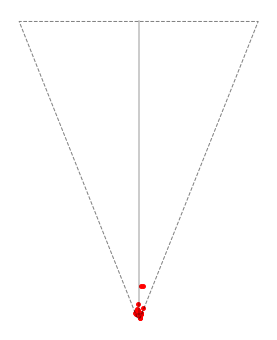

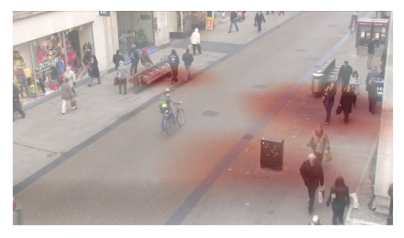

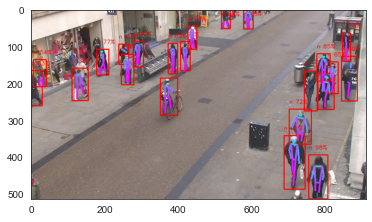

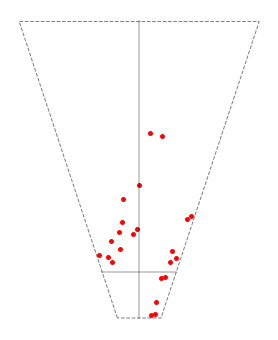

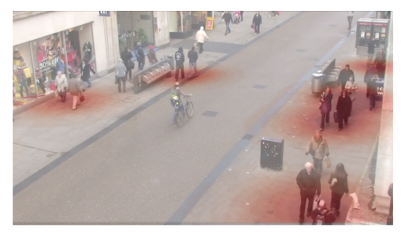

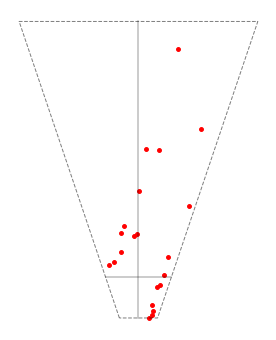

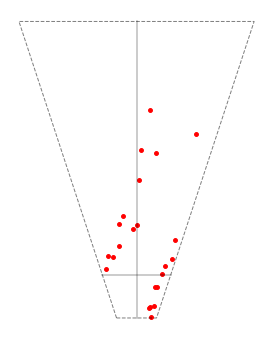

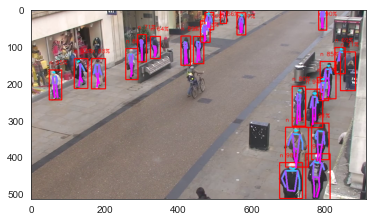

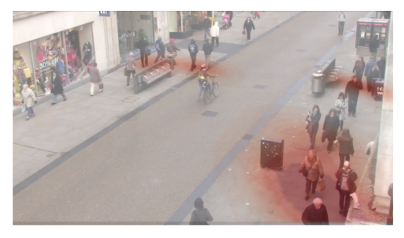

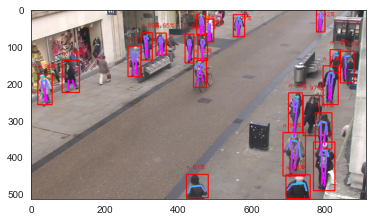

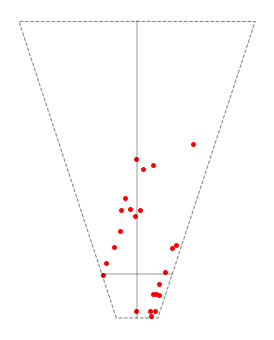

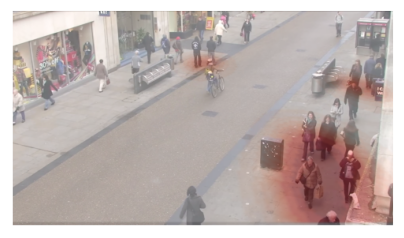

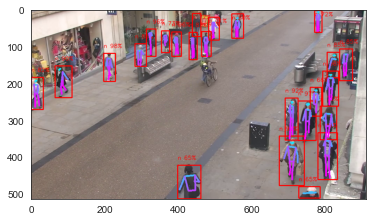

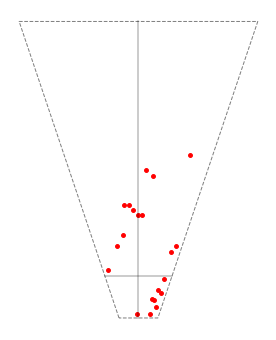

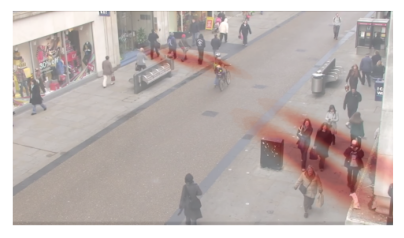

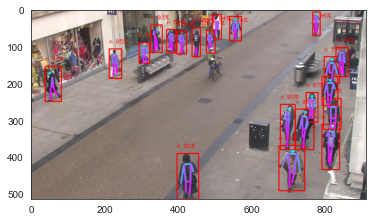

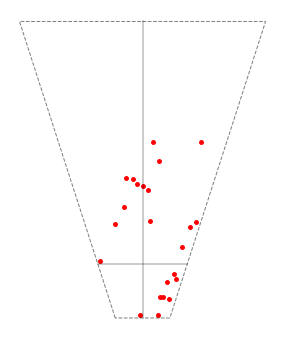

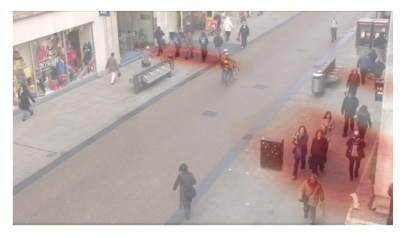

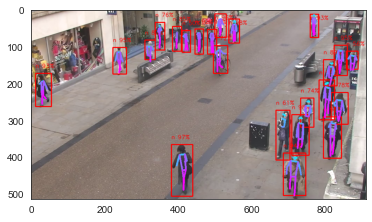

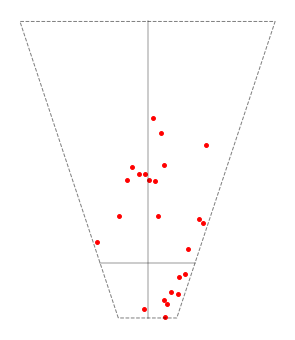

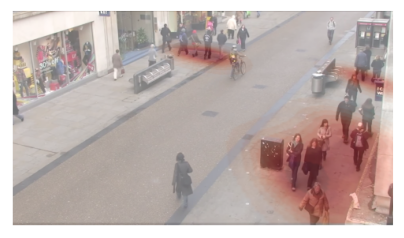

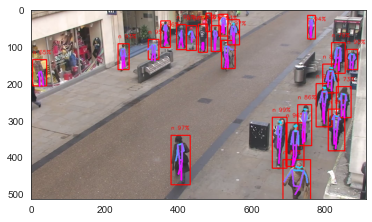

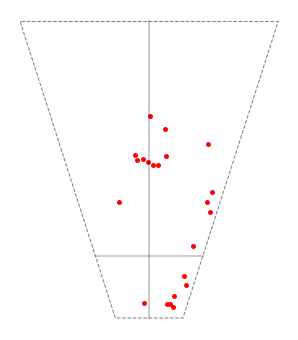

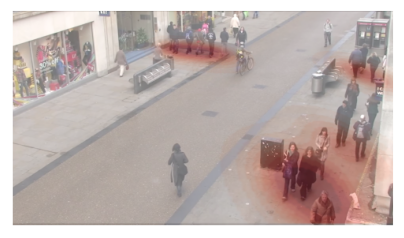

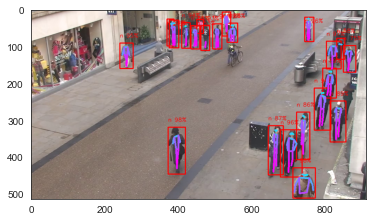

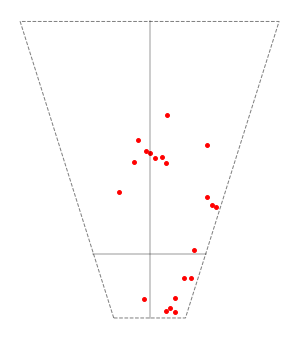

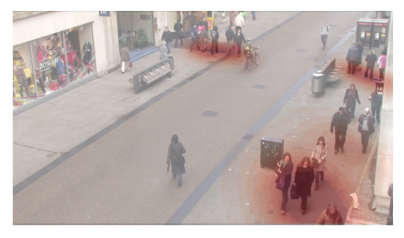

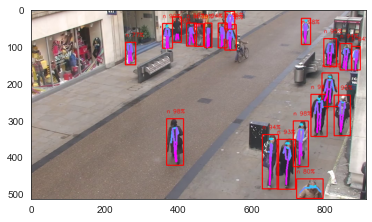

In [25]:
# reset to suitable plot params
%matplotlib inline 
sns.set_style('white')

# load uploaded video into opencv:
cap = cv2.VideoCapture(TEST_VIDEO_FILEPATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# initially current frame is zero
frame_count = 0

# dictionary for scene-summary results (e.g. person counts, mask %)
frame_results = {'image_id' : [],
                 'person_count' : [],
                 'clusters_count' : [],
                 'social_distancing_compliance' : [],
                 'mask_count' : [],
                 'mask_proportions' : [], 
                 'standing_count' : [],
                 'sitting_count' : [],
                 'standing_proportions' : [],
                 'frame_H' : [],
                 'frame_theta' : [],
                 'frame_f' : [],
                 'frame_dim_x' : [],
                 'frame_dim_y' : [],
                 'total_risk_profile' : []}

# dictionary for per-person level results (bbox, keypoints, mask_on etc.)
person_results = {'image_id' : [],
                  'bbox' : [],
                  'keypoints' : [],
                  'confidences' : [],
                  'position' : [],
                  'in_cluster' : [],
                  'respect_social_distancing' : [],
                  'behavior' : [],
                  'behavior_score' : [],
                  'mask_preds' : [],
                  'mask_pred_probs' : [],
                  'mask_head_regions' : [],
                  'person_risk_weights' : []}

# container to store risk density-heatmaps
frame_heatmaps = []

# parameters tracking
time_step_average = 120
theta_queue = deque()
H_queue = deque()
f_queue = deque()

# whilst processing video, do the following loop..
while(True):

    # check video capture, and obtain current frame (image from video)
    ret, vid_frame = cap.read()

    # if our video is still being processed, do the following...
    if(ret):

        # preprocess frame as required for object detector & AlphaPose
        frame = mx.nd.array(cv2.cvtColor(vid_frame, 
                                         cv2.COLOR_BGR2RGB)).astype('uint8')
        x, frame = gluoncv.data.transforms.presets.ssd.transform_test(frame, 
                                                        short=VID_RESIZE_SHORT)
        x = x.as_in_context(ctx)

        # obtain human bounding boxes using object detector
        class_IDs, scores, bounding_boxs = detector(x)

        # get pose estimations using AlphaPose
        pose_input, upscale_bbox = detector_to_alpha_pose(frame, class_IDs, 
                                                          scores, bounding_boxs)

        # add frame id, person count to frame-level results
        image_id = f"frame_{int(frame_count)}"
        n_people = upscale_bbox.shape[0]
        frame_results['image_id'].append(image_id)
        frame_results['person_count'].append(n_people)

        # add frame_id, person bbox to person-level results
        person_results['image_id'].append([image_id for x in range(n_people)])
        person_results['bbox'].append(upscale_bbox)

        # if we have predictions, obtain keypoint co-ords and confidences
        if upscale_bbox is not None:

            # obtain predicted heatmap
            predicted_heatmap = estimator(pose_input.as_in_context(ctx))

            # obtain keypoint co-ordinates from heatmap results
            pred_coords, confidence = heatmap_to_coord(predicted_heatmap, 
                                                       upscale_bbox)
            
            # add person keypoints and confidences to person-level results
            person_results['keypoints'].append(pred_coords.asnumpy())
            person_results['confidences'].append(confidence.asnumpy())

            ########################################################
            ######### DOWNSTREAM MODELLING PROCESSING AREA #########
            ########################################################
            
            ####### DISTANCE ESTIMATION / CLUSTERING #########
            
            # obtain x / y dims of frame
            image_dim_y, image_dim_x = frame.shape[:2]
            
            # obtain estimation of parameters of the camera 
            _, _, theta, H, f = from_2D_to_3D(pred_coords, image_dim_x, 
                                              image_dim_y)
            
            # update parameters tracking lists
            if len(theta_queue) > time_step_average:
                theta_queue.popleft()
                H_queue.popleft()
                f_queue.popleft()
            theta_queue.append(theta)
            H_queue.append(H)
            f_queue.append(f)
            
            # use z-scores to remove extreme values (95% confidence)
            zscore_select_theta = np.where(
                            np.abs((np.array(theta_queue) - np.mean(theta_queue)) 
                                   / np.std(theta_queue)) < 1.96)[0]
            
            zscore_select_H = np.where(
                        np.abs((np.array(H_queue) - np.mean(H_queue)) 
                               / np.std(H_queue)) < 1.96)[0]
            
            zscore_select_f = np.where(
                        np.abs((np.array(f_queue) - np.mean(f_queue)) 
                               / np.std(f_queue)) < 1.96)[0]
            
            zscore_select = np.intersect1d(zscore_select_theta, 
                                           np.intersect1d(zscore_select_H, 
                                                          zscore_select_f))
            # remove extreme values
            if len(zscore_select) > 10:
                theta = np.mean(np.array(theta_queue)[zscore_select])
                H = np.mean(np.array(H_queue)[zscore_select])
                f = np.mean(np.array(f_queue)[zscore_select])
            else:
                theta, H, f = np.mean(theta_queue), np.mean(H_queue), np.mean(f_queue)
            
            # obtain estimation of persons' positions
            X, Y, _, _, _ = from_2D_to_3D(pred_coords, image_dim_x, 
                                          image_dim_y, theta, H, f)
            
            # get positions into a single array
            positions = np.column_stack([X, Y])
            
            # obtain social distancing compliance classification
            respect_social_distancing = get_respect_social_distancing(positions, 
                                                                      social_distance=2)
            
            # get compliance proportion in scene
            compliance_prop = np.array(np.bincount(respect_social_distancing, 
                                                   minlength=2)[1] 
                                       / respect_social_distancing.shape[0])
            
            # obtain social clusters
            persons_clusters = get_clusters(positions, treshold=1)
            
            # get cluster classification (0 = not in a cluster, 1 = in a cluster)
            in_cluster = (persons_clusters >= 0).astype(int)
            
            # plot top view of the scene if selected
            if SHOW_TOP_VIEW: 
                plot_top_view(positions, H, theta, f, 
                              image_dim_x, image_dim_y)
            
            # plot social clusters if chosen
            if SHOW_SOCIAL_GROUPS:
                plot_clusters(frame, persons_clusters, upscale_bbox)

            # append positions, clusters and social distancing compliance results to per-person results
            person_results['position'].append(positions)
            person_results['in_cluster'].append(in_cluster)
            person_results['respect_social_distancing'].append(respect_social_distancing)

            # add number of clusters and compliance proportion to frame-results
            frame_results['clusters_count'].append(np.max(persons_clusters)+1)
            frame_results['social_distancing_compliance'].append(compliance_prop)
            
            # add the frame img dimensions and derived homography params to frame results
            frame_results['frame_H'].append(H)
            frame_results['frame_theta'].append(theta)
            frame_results['frame_f'].append(f)
            frame_results['frame_dim_x'].append(image_dim_x)
            frame_results['frame_dim_y'].append(image_dim_y)
            
            
            ####### POSE STATUS CLASSIFICATION ############
            
            # get predictions for pose status
            label, score = behavior_analysis(pred_coords, 
                                             upscale_bbox,
                                             behavior_analysis_model)
            
            # add results to our person-level results
            person_results['behavior'].append(label)
            person_results['behavior_score'].append(score)
            
            # determine counts & proportions for status of scene
            status_counts = np.bincount(label, minlength=4)

            # simplify standing by combining standing [1] & walking [3]
            stand_count = status_counts[0] + status_counts[2]
            
            # simplify sitting by combining sitting [2] and lying [4]
            sitting_count = status_counts[1] + status_counts[3]
        
            # append sitting and standing counts to frame results
            frame_results['standing_count'].append(stand_count)
            frame_results['sitting_count'].append(sitting_count)
            
            # add standing proportion to frame results
            standing_prop = np.array(stand_count / label.shape[0])
            frame_results['standing_proportions'].append(standing_prop)

            # get pose status risk-factor array from pose status labels
            pose_factors = np.vectorize(BEH_RISK_FACTORS.__getitem__)(label)
            
            
            ####### MASK CLASSIFICATION CODE #######

            # obtain head regions boxes from our pose features
            head_regions = compute_head_boxes(pred_coords)

            # get extract tensor of head regions from original frame
            region_tensor = get_image_region_array(frame, head_regions)
            
            # obtain probabilities (softmax normalised) from model
            mask_pred_probs = model_predict_probs(trained_module, region_tensor)

            # obtain hard class labels from our probabilities - use threshold
            mask_preds = get_prediction_labels(mask_pred_probs, 
                                               MASK_THRESHOLD).numpy()

            # if desired, plot the mask classifier predictions
            if SHOW_MASK_PREDS:
                # plot our predicted mask results with original image
                plot_mask_predictions(frame, mask_preds, mask_pred_probs, 
                                      head_regions)

            # get mask proportion in scene, add to our total results
            mask_count = np.bincount(mask_preds, minlength=2)[1]
            mask_prop = np.array(mask_count / mask_preds.shape[0])

            # append mask results to per-person results
            person_results['mask_preds'].append(mask_preds)
            person_results['mask_pred_probs'].append(mask_pred_probs)
            person_results['mask_head_regions'].append(head_regions)

            # add mask counts and proportions to frame-results
            frame_results['mask_count'].append(mask_count)
            frame_results['mask_proportions'].append(mask_prop)

            ############################################
            ######### DOWNSTREAM MODELLING END #########
            ############################################
            
            ############################################
            ######### DENSITY HEATMAP MODELLING ########
            ############################################
            
            # get frame params needed for density heatmap
            hgraphy_params = [H, theta, f]
            image_dims = [image_dim_x, image_dim_y]
            
            # get risk-based weights using predictions for each person
            person_weights = get_sample_weights(mask_preds, 
                                        respect_social_distancing,
                                        pose_factors,
                                        MASK_FACTOR, VIOLATION_FACTOR,
                                        POSE_STATUS_FACTOR)
            
            # append person weights to our person results
            person_results['person_risk_weights'].append(person_weights)
            
            # also add risk profile (summed person weights) to frame results
            frame_results['total_risk_profile'].append(person_weights.sum())
            
            # get density heatmap for current frame
            frame_heatmap = get_density_heatmap_on_frame(frame, positions, 
                                                         person_weights, 
                                                         hgraphy_params, 
                                                         image_dims)
            
            # append current frame heatmap to total results
            frame_heatmaps.append(frame_heatmap)
            
            # if desired plot frame density heatmap
            if SHOW_FRAME_HEATMAP:
                plt.figure(figsize=(7,6))
                plt.imshow(frame_heatmap)
                plt.axis('off')
                plt.show()
                
            ############################################
            ######### DENSITY HEATMAP END ##############
            ############################################
            
            # if selected, plot alphapose results
            if SHOW_POSES:
                # annotate our original frame with alphapose extracted keypoints
                frame_cp = frame.copy()
                img = cv_plot_keypoints(frame_cp, pred_coords, confidence, class_IDs, 
                                        bounding_boxs, scores,
                                        box_thresh=0.5, keypoint_thresh=0.2)
                
                # plot alphapose results
                plot_image(img)

        # if no alphapose keypoints found, just plot the frame (image)
        else:
            plot_image(img)
        
        # increment current frame by amount selected by MODELLING_FPS
        frame_count += fps / MODELLING_FPS
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_count))

    # break loop if video is not available / ended
    else:
        break

    if cv2.waitKey(1) == 27:
        break

# empty video capture cache
cap.release()
cv2.destroyAllWindows()

**Animation of all heatmaps obtained above against original scene:**

Lets show this as a sequence of heatmaps above the original video.

<IPython.core.display.Javascript object>


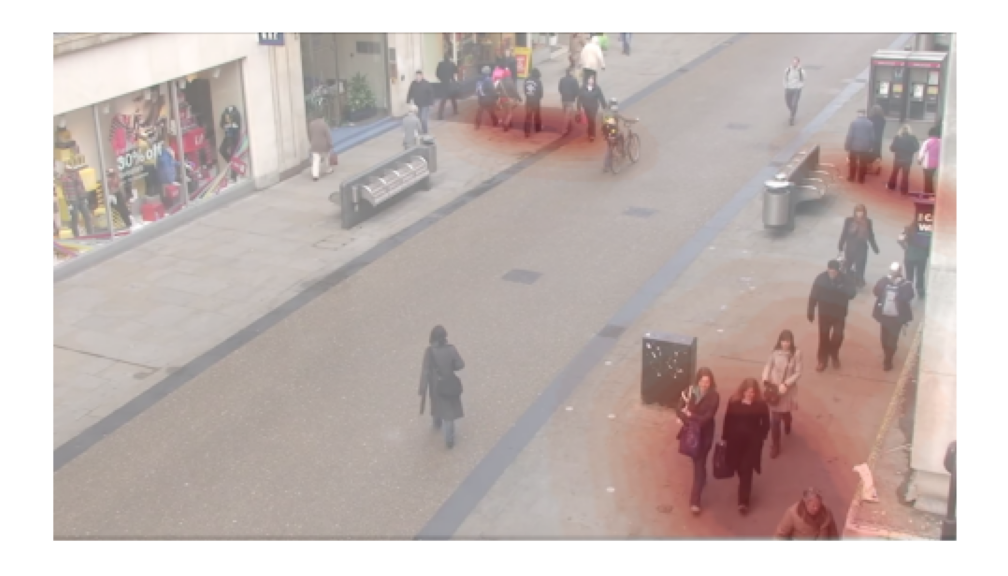

In [26]:
# need to enable matplotlib notebook to show animations
from matplotlib import animation
%matplotlib notebook

# plot our sequence of heatmap images as one animation
fig, ax = plt.subplots(figsize=(7,4))
ims = []
for i in range(len(frame_heatmaps)):
    im = ax.imshow(frame_heatmaps[i], animated=True)
    ims.append([im])

# animate our heatmap based on modelling fps chosen earlier
# make this slower (by 50%) to improve readability in this example
ani = animation.ArtistAnimation(fig, ims, interval=1000/MODELLING_FPS, 
                                blit=True, repeat=False)
plt.axis('off')
plt.tight_layout()
plt.show()

Also save this sequence as a gif (if desired):

In [28]:
f = f"{TEST_VIDEO_DIR}/{TEST_VIDEO_FILE[:-4]}_heatmap_animation.gif" 
writergif = animation.PillowWriter(fps=MODELLING_FPS) 
ani.save(f, writer=writergif)

Furthermore, we can analyse the total risk for the scene over the entire timescale (e.g. all timeframes above). We can do this through using all timeframes, rather than just a set of single frame results, which will indicate the most risky-areas within a scene.

We'll do this after converting our results to dataframes, as further below.

Now that we have all of our results, it's more helpful to convert them into dataframes, prior to conversion into JSON objects, which can then be sent to our API / front-end application easily as required.

## 5. Conversion of final results into Pandas dataframes, and exporting to JSON objects:

Lets convert the results obtained from this into a final form, suitable for further analysis / passing to the API & Dashboard:

In [29]:
final_frame_results = {}

# standardise frame-level results as np arrays for consistency
for key in frame_results.keys():
        print(f"Key {key}, length: {len(frame_results[key])}")
        final_frame_results[key] = np.array(frame_results[key])

# convert frame-level results to dataframe for ease of analysis
final_frame_results = pd.DataFrame(final_frame_results)

# preview results format
final_frame_results.tail()

Key image_id, length: 11
Key person_count, length: 11
Key clusters_count, length: 11
Key social_distancing_compliance, length: 11
Key mask_count, length: 11
Key mask_proportions, length: 11
Key standing_count, length: 11
Key sitting_count, length: 11
Key standing_proportions, length: 11
Key frame_H, length: 11
Key frame_theta, length: 11
Key frame_f, length: 11
Key frame_dim_x, length: 11
Key frame_dim_y, length: 11
Key total_risk_profile, length: 11


image_id  person_count  clusters_count  social_distancing_compliance  \
6    frame_75            21               1                      0.571429   
7    frame_87            23               1                      0.434783   
8   frame_100            24               1                      0.500000   
9   frame_112            22               3                      0.318182   
10  frame_125            21               3                      0.333333   

    mask_count  mask_proportions  standing_count  sitting_count  \
6            4          0.190476              20              1   
7            4          0.173913              23              0   
8            5          0.208333              21              3   
9            2          0.090909              19              3   
10           3          0.142857              20              1   

    standing_proportions   frame_H  frame_theta      frame_f  frame_dim_x  \
6               0.952381  7.300016     0.266462  1303.142330          910   
7               1.000000  8.035643     0.289301  1350.488865          910   
8               0.875000  8.057552     0.302152  1309.750621          910   
9               0.863636  8.492827     0.314093  1346.967020          910   
10              0.952381  8.694679     0.319090  1368.644306          910   

    frame_dim_y  total_risk_profile  
6           512                13.0  
7           512                19.0  
8           512                18.0  
9           512                23.5  
10          512                20.5

In [30]:
final_person_results = {}

# convert mask results into np array form and flatten
for key in person_results.keys():
        final_person_results[key] = np.concatenate(person_results[key], axis=0)
        final_person_results[key] = final_person_results[key].tolist()

# convert final person-level results to dataframe
final_person_results = pd.DataFrame(final_person_results)

# preview results
final_person_results.head()

image_id                          bbox  \
0  frame_0  [678.0, 318.0, 753.0, 507.0]   
1  frame_0   [423.0, 33.0, 454.0, 116.0]   
2  frame_0  [746.0, 374.0, 814.0, 511.0]   
3  frame_0  [240.0, 108.0, 284.0, 215.0]   
4  frame_0   [402.0, 73.0, 436.0, 176.0]   

                                           keypoints  \
0  [[713.9375, 359.34375], [717.0625, 353.4375], ...   
1  [[440.4375, 47.265625], [438.5, 43.375], [440....   
2  [[780.0, 466.046875], [795.5833129882812, 457....   
3  [[261.0833435058594, 126.390625], [264.75, 156...   
4  [[419.0, 93.921875], [418.2916564941406, 93.92...   

                                         confidences  \
0  [[0.6503492593765259], [0.6452330350875854], [...   
1  [[0.011882076971232891], [0.007165077142417431...   
2  [[0.004148545209318399], [0.003191364463418722...   
3  [[0.003193708136677742], [0.008510438725352287...   
4  [[0.009138527326285839], [0.006069561466574669...   

                                    position  in_cluster  \
0   [3.094141887667188, -10.838722172458194]           0   
1  [-0.8013733784723196, 35.715212683861374]           0   
2  [3.5234998983222714, -12.023014244283598]           0   
3     [-5.40235193301016, 7.567148270157814]           0   
4   [-1.212110561218608, 13.979036732226568]           0   

   respect_social_distancing  behavior  behavior_score  mask_preds  \
0                          0         2        0.861810           0   
1                          1         2        0.773854           0   
2                          0         2        0.777024           0   
3                          1         2        0.705988           1   
4                          0         2        0.781503           0   

                             mask_pred_probs   mask_head_regions  \
0  [0.9664742350578308, 0.03352568671107292]  [692, 332, 45, 45]   
1  [0.5448437333106995, 0.45515626668930054]   [427, 33, 24, 24]   
2    [0.5155073404312134, 0.484492689371109]  [757, 412, 47, 47]   
3    [0.1905599683523178, 0.809440016746521]  [250, 133, 24, 24]   
4   [0.3337526321411133, 0.6662473678588867]   [405, 80, 26, 26]   

   person_risk_weights  
0                  1.5  
1                  0.0  
2                  1.5  
3                  0.0  
4                  1.5

Now that we have these as pandas dataframes, they can be exported easily into JSON objects, like so:

In [31]:
frame_json_results = final_frame_results.to_json()
person_json_results = final_person_results.to_json()

These JSON strings can now be packaged and sent to an API (or any desired location) as required.

When received by our API, the results can easily be decoded and read again into pandas, like so:

In [32]:
frame_results = pd.read_json(frame_json_results)
frame_results.head()

image_id  person_count  clusters_count  social_distancing_compliance  \
0   frame_0            22               0                      0.636364   
1  frame_12            23               1                      0.434783   
2  frame_25            21               0                      0.523810   
3  frame_37            23               2                      0.608696   
4  frame_50            22               1                      0.500000   

   mask_count  mask_proportions  standing_count  sitting_count  \
0           3          0.136364              19              3   
1           3          0.130435              21              2   
2           3          0.142857              18              3   
3           7          0.304348              20              3   
4           3          0.136364              18              4   

   standing_proportions   frame_H  frame_theta      frame_f  frame_dim_x  \
0              0.863636  5.471183     0.231576  1112.102583          910   
1              0.913043  7.198596     0.272485  1323.422330          910   
2              0.857143  7.297416     0.265796  1298.606605          910   
3              0.869565  7.387971     0.264106  1334.578545          910   
4              0.818182  7.124261     0.269064  1278.261880          910   

   frame_dim_y  total_risk_profile  
0          512                12.5  
1          512                19.5  
2          512                14.5  
3          512                12.0  
4          512                17.0

In [33]:
person_results = pd.read_json(person_json_results)
person_results.head()

image_id                          bbox  \
0  frame_0  [678.0, 318.0, 753.0, 507.0]   
1  frame_0   [423.0, 33.0, 454.0, 116.0]   
2  frame_0  [746.0, 374.0, 814.0, 511.0]   
3  frame_0  [240.0, 108.0, 284.0, 215.0]   
4  frame_0   [402.0, 73.0, 436.0, 176.0]   

                                           keypoints  \
0  [[713.9375, 359.34375], [717.0625, 353.4375], ...   
1  [[440.4375, 47.265625], [438.5, 43.375], [440....   
2  [[780.0, 466.046875], [795.5833129883, 457.484...   
3  [[261.0833435059, 126.390625], [264.75, 156.48...   
4  [[419.0, 93.921875], [418.2916564941, 93.92187...   

                                         confidences  \
0  [[0.6503492594], [0.6452330351000001], [0.6716...   
1  [[0.011882077000000001], [0.0071650771], [0.01...   
2  [[0.0041485452], [0.0031913645], [0.0050686998...   
3  [[0.0031937081], [0.008510438700000001], [0.00...   
4  [[0.009138527300000001], [0.0060695615], [0.01...   

                         position  in_cluster  respect_social_distancing  \
0  [3.0941418877, -10.8387221725]           0                          0   
1  [-0.8013733785, 35.7152126839]           0                          1   
2  [3.5234998983, -12.0230142443]           0                          0   
3    [-5.402351933, 7.5671482702]           0                          1   
4  [-1.2121105612, 13.9790367322]           0                          0   

   behavior  behavior_score  mask_preds                      mask_pred_probs  \
0         2        0.861810           0   [0.9664742351000001, 0.0335256867]   
1         2        0.773854           0  [0.5448437333, 0.45515626670000003]   
2         2        0.777024           0         [0.5155073404, 0.4844926894]   
3         2        0.705988           1         [0.1905599684, 0.8094400167]   
4         2        0.781503           0         [0.3337526321, 0.6662473679]   

    mask_head_regions  person_risk_weights  
0  [692, 332, 45, 45]                  1.5  
1   [427, 33, 24, 24]                  0.0  
2  [757, 412, 47, 47]                  1.5  
3  [250, 133, 24, 24]                  0.0  
4   [405, 80, 26, 26]                  1.5

**Save JSON results to file:**

Lets save our JSON results to the test video directory, so that we can load these in another notebook and work towards developing the final dashboard visualisations required:

In [34]:
# set paths to save results as JSON files (within test video dir)
PERSON_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_person_results.JSON")
FRAME_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_frame_results.JSON")

In [35]:
# save to results
frame_results.to_json(FRAME_RESULTS_FILEPATH)
person_results.to_json(PERSON_RESULTS_FILEPATH)

## 6. Visualising total risk over the scene (across all timesteps):

In [36]:
# reset to suitable plot params
%matplotlib inline 
sns.set_style('white')

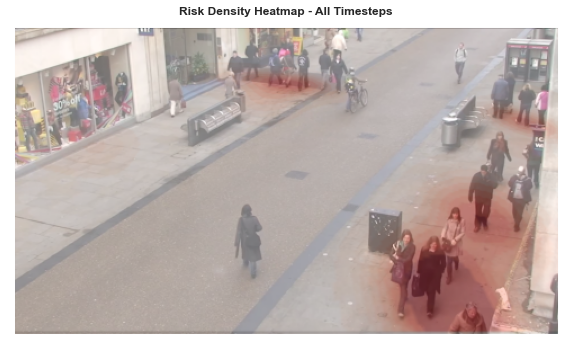

In [37]:
# get all positions and weights across all timesteps
person_posns = np.stack(person_results['position'])
person_weights = person_results['person_risk_weights'].values

# get final homography params for frame
hgraphy_params = frame_results.iloc[-1][['frame_H', 
                                         'frame_theta', 
                                         'frame_f']].values

# get frame img dims
img_dims = frame_results.iloc[-1][['frame_dim_x', 
                                         'frame_dim_y']].values

# get associated density heatmap for all timesteps
total_density_heatmap = get_density_heatmap_on_frame(frame, person_posns, person_weights, 
                                                     hgraphy_params, img_dims)

plt.figure(figsize=(10,7))
plt.imshow(total_density_heatmap)
plt.axis('off')
plt.title('Risk Density Heatmap - All Timesteps', weight='bold')
plt.show()

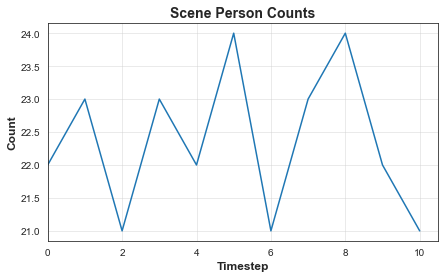

In [39]:
frame_results['person_count'].plot(figsize=(7,4))
plt.title("Scene Person Counts", weight="bold", size=14)
plt.xlabel("Timestep", weight="bold", size=12)
plt.ylabel("Count", weight="bold", size=12)
plt.grid(alpha=0.5)
plt.xlim(0.0)
plt.show()

We can make our plotting of person counts much more informative through using a stackplot instead, with colours corresponding to status, as below:

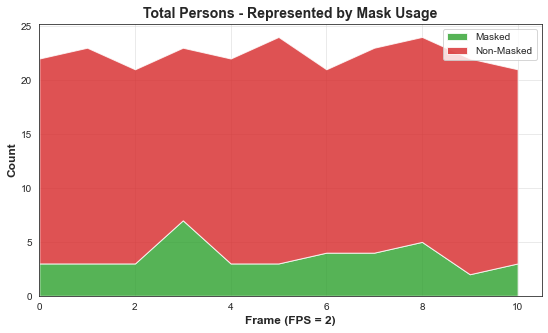

In [40]:
plt.figure(figsize=(9,5))
plt.stackplot(frame_results.index.values, frame_results['mask_count'],
              frame_results['person_count'] - frame_results['mask_count'],
              alpha=0.8, labels=['Masked', 'Non-Masked'], 
              colors=['Tab:Green', 'Tab:Red'])
plt.xlim(0.0)
plt.ylim(0.0)
plt.title("Total Persons - Represented by Mask Usage", weight="bold", size=14)
plt.xlabel(f"Frame (FPS = {MODELLING_FPS})", weight="bold", size=12)
plt.ylabel("Count", weight="bold", size=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

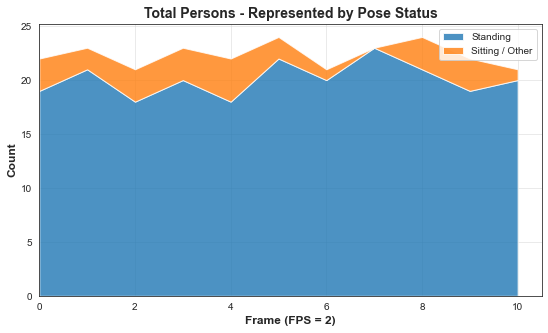

In [41]:
plt.figure(figsize=(9,5))
plt.stackplot(frame_results.index.values, frame_results['standing_count'],
              frame_results['person_count'] - frame_results['standing_count'],
              alpha=0.8, labels=['Standing', 'Sitting / Other'], 
              colors=['Tab:Blue', 'Tab:Orange'])
plt.xlim(0.0)
plt.ylim(0.0)
plt.title("Total Persons - Represented by Pose Status", weight="bold", size=14)
plt.xlabel(f"Frame (FPS = {MODELLING_FPS})", weight="bold", size=12)
plt.ylabel("Count", weight="bold", size=12)
plt.legend(loc="best")
plt.grid(alpha=0.5)
plt.show()

Scene Proportions:

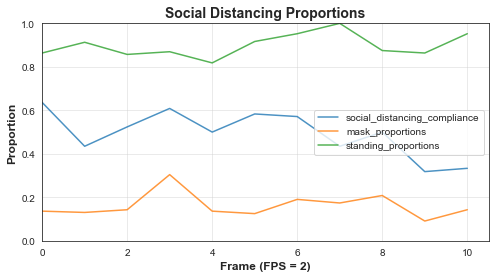

In [42]:
frame_results[['social_distancing_compliance', 
               'mask_proportions',
               'standing_proportions']].plot(figsize=(8,4), alpha=0.8)
plt.xlim(0.0)
plt.ylim(0.0, 1.0)
plt.title("Social Distancing Proportions", weight="bold", size=14)
plt.xlabel(f"Frame (FPS = {MODELLING_FPS})", weight="bold", size=12)
plt.ylabel("Proportion", weight="bold", size=12)
plt.grid(alpha=0.5)
plt.show()

We can also look at our total risk profile, which is the total sum of person risk-weights for each frame:

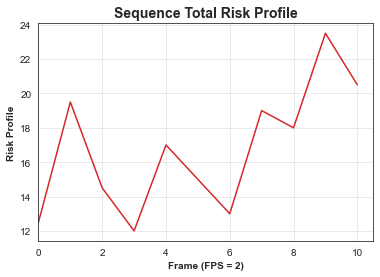

In [43]:
frame_results['total_risk_profile'].plot(c='tab:red')
plt.title("Sequence Total Risk Profile", weight="bold", size=14)
plt.ylabel("Risk Profile", weight="bold")
plt.xlabel(f"Frame (FPS = {MODELLING_FPS})", weight="bold")
plt.xlim(0.0)
plt.grid(alpha=0.5)
plt.show()

This can help identify the most risky time-periods in a video sequence, which could be useful for analysing past data at the airport.